In [393]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

In [394]:
df = pd.read_csv('wine_Austral2.dat', sep='\t')
df.tail()

,fort,dry,sweet,red,rose,spark,total,year_,month_,date_
169,1568,3685,280,1728,35,1968,22784,1994,2,FEB 1994
170,1965,3754,187,2201,42,1720,23565,1994,3,MAR 1994
171,2659,3708,279,2455,48,1725,26323,1994,4,APR 1994
172,2354,3210,193,2204,44,1674,23779,1994,5,MAY 1994
173,2592,3517,227,2660,45,1693,27549,1994,6,JUN 1994


In [395]:
df.describe()

,fort,dry,sweet,red,rose,spark,total,year_,month_
count,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000
mean,3010.183908,3196.724138,246.362069,1591.270115,93.005747,2402.442529,25379.321839,1986.758621,6.396552
std,879.744321,682.859826,124.864046,582.974416,38.753929,1295.902839,5359.545072,4.202849,3.460460
min,1154.000000,1954.000000,85.000000,464.000000,30.000000,1170.000000,13652.000000,1980.000000,1.000000
25%,2371.750000,2726.500000,139.250000,1108.000000,66.000000,1605.000000,22094.250000,1983.000000,3.000000
50%,2898.000000,3073.000000,215.500000,1542.500000,87.000000,1866.500000,24669.000000,1987.000000,6.000000
75%,3565.000000,3629.500000,319.750000,2075.250000,114.250000,2513.500000,28408.250000,1990.000000,9.000000
max,5618.000000,5587.000000,662.000000,3330.000000,267.000000,7242.000000,40226.000000,1994.000000,12.000000


In [396]:
#  Процедура сезонной декомпозиции
from statsmodels.tsa.seasonal import seasonal_decompose

<AxesSubplot:>

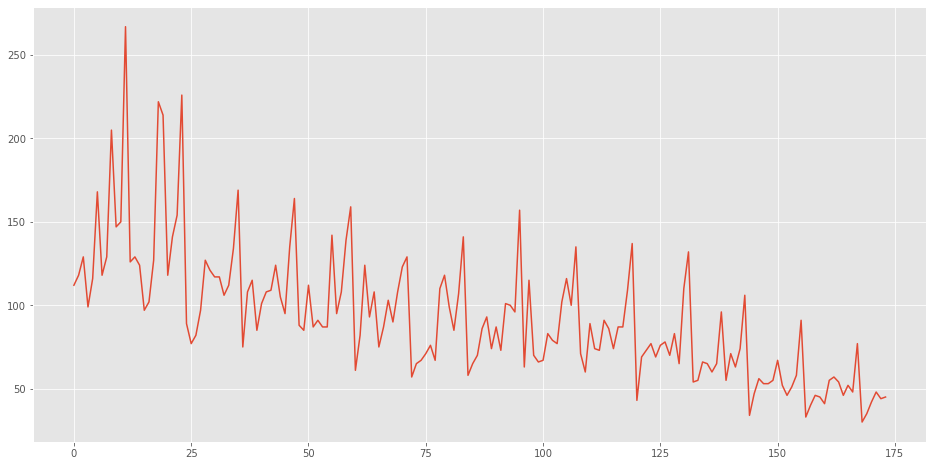

In [397]:
#  Временной ряд столбца "rose":
df_rose = df["rose"]
df_rose.plot(figsize=(16,8))

In [398]:
result = seasonal_decompose(df_rose, model='multiplicative', period=12)

<Figure size 2160x720 with 0 Axes>

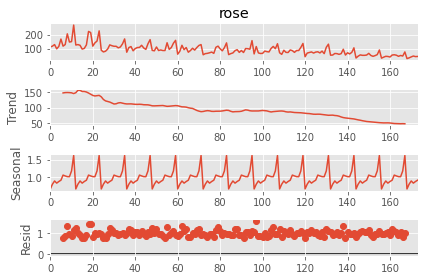

In [399]:
#  Результаты сезонной декомпозиции:
plt.figure(figsize=(30,10))
result.plot()
plt.tight_layout()

Тренд.
Обратите внимание: сезонная составляющая ряда отсутствует.
Она отфильтрована скользящим средним

Text(0.5, 1.0, 'Тренд')

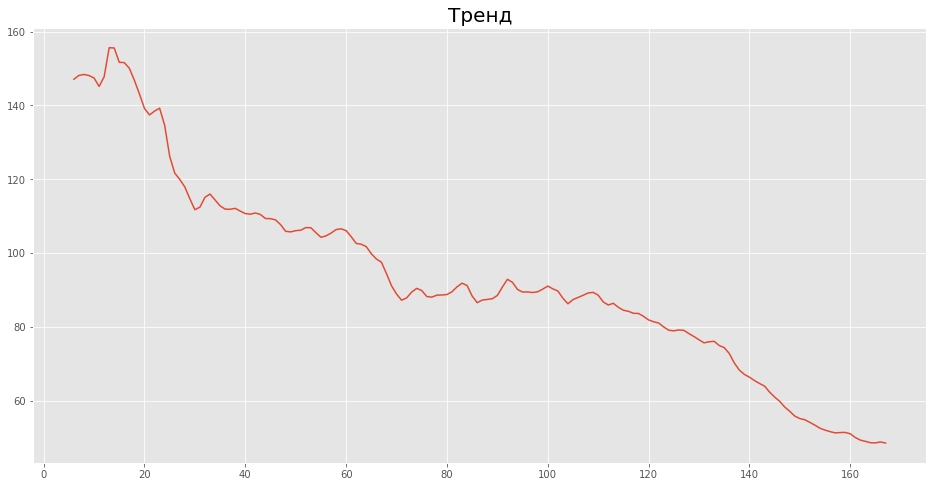

In [400]:
#  график тренда: 6 пропусков в начале, 6 - в конце:
plt.figure(figsize=(16,8))
result.trend.plot()
plt.title("Тренд", fontsize=20)

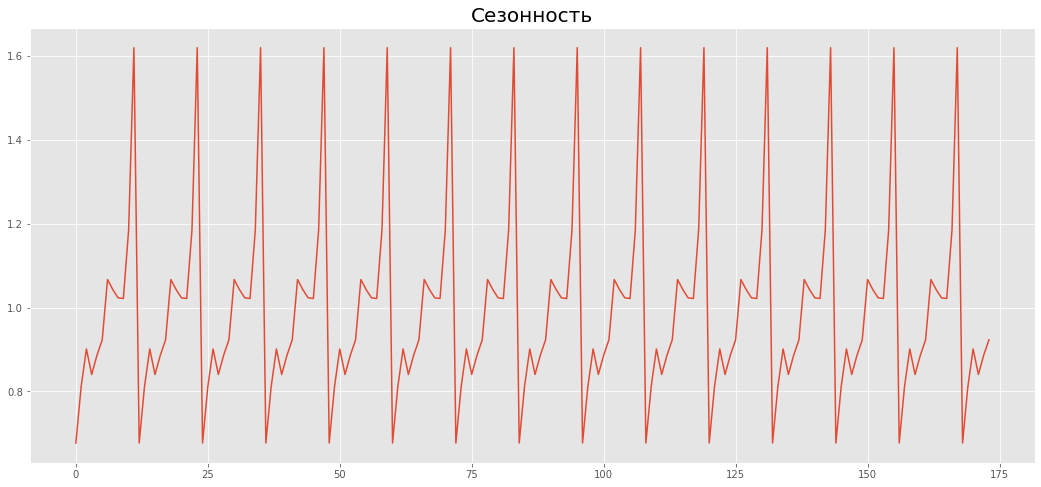

In [401]:
# график сезонности:
plt.figure(figsize=(18,8))
result.seasonal.plot()
plt.title("Сезонность", fontsize=20)
plt.show()

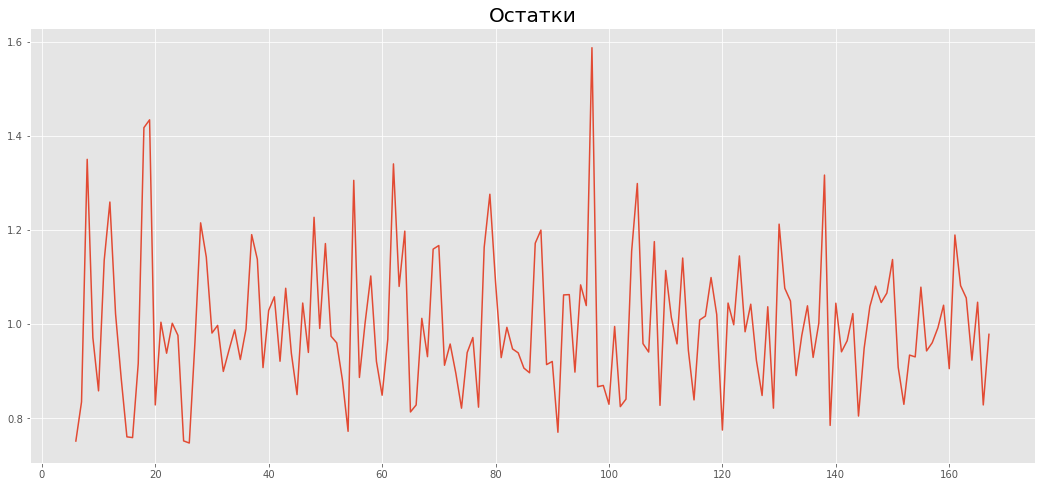

In [402]:
#  график остатков:
plt.figure(figsize=(18,8))
result.resid.plot()
plt.title("Остатки", fontsize=20)
plt.show()

Прикинем какие у нас перспективы при прогнозировании: остатки бьются в интервале +-0.2, то есть максимальная ошибка - 20%. Значит для выбранного ряда сезонная декомпозиция может сработать.

In [403]:
#  Ряд, очищенный от сезонности: Тренд * ошибка 
#  Внимание:  на сезонность делим, так как модель мультипликативна:
df_rose_season = df_rose / result.seasonal

Text(0.5, 1.0, 'SA plot')

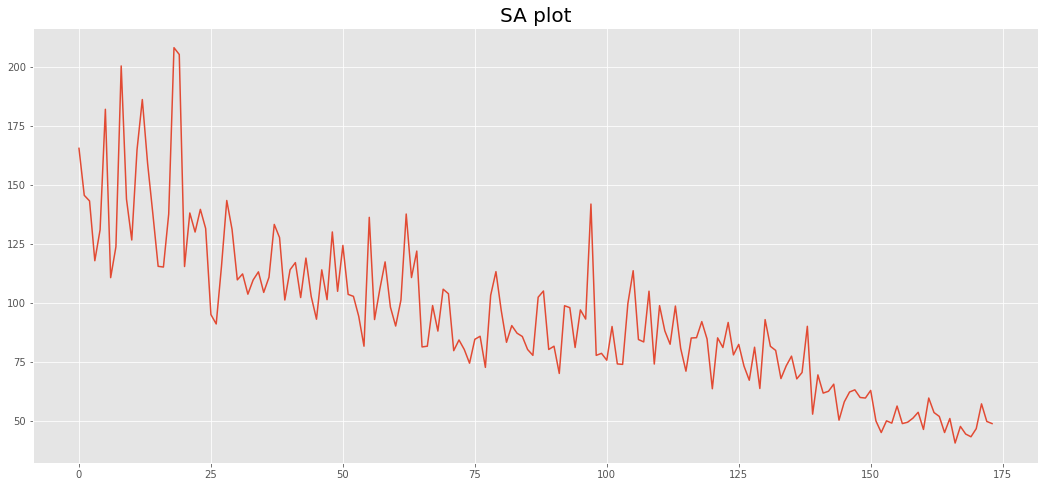

In [404]:
#  SA сокращение от "seasonally adjusted time series" 
#  то есть ряд с удаленной сезонностью:
plt.figure(figsize=(18,8))
df_rose_season.plot()
plt.title("SA plot", fontsize=20)

Text(0.5, 1.0, 'Исходный ряд и SA ряд')

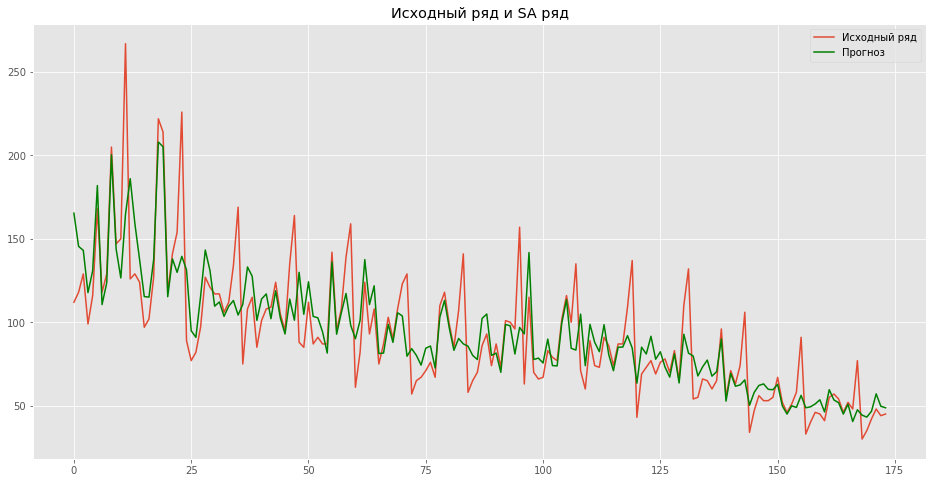

In [405]:
#  Исходный ряд и SA ряд

plt.figure(figsize=(16,8))
plt.plot(df_rose, label='Исходный ряд')
plt.plot(df_rose_season, label='Прогноз', c = 'green')
plt.legend(loc='best')

plt.title(u'Исходный ряд и SA ряд')

In [406]:
result.trend

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
169   NaN
170   NaN
171   NaN
172   NaN
173   NaN
Name: trend, Length: 174, dtype: float64

In [407]:
result.trend.head(12)

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
5            NaN
6     147.083333
7     148.125000
8     148.375000
9     148.083333
10    147.416667
11    145.125000
Name: trend, dtype: float64

In [408]:
result.trend.tail(12)

162    49.375000
163    49.041667
164    48.666667
165    48.625000
166    48.875000
167    48.583333
168          NaN
169          NaN
170          NaN
171          NaN
172          NaN
173          NaN
Name: trend, dtype: float64

In [409]:
#  От центрированного скользящего среднего переходим к опережающему скользящему среднему?
trend_2 = result.trend.dropna()
trend_2

# ряд стал на 12 наблюдений короче

6      147.083333
7      148.125000
8      148.375000
9      148.083333
10     147.416667
          ...    
163     49.041667
164     48.666667
165     48.625000
166     48.875000
167     48.583333
Name: trend, Length: 162, dtype: float64

Прогнозируем тренд, используя полиномиальную регрессию.
Готовим предикторы

**Центрированное скользящее среднее.** Среднее на промежутке значений ряда, окружающем и включающем текущее значение. </br>
**Опережающее скользящее среднее.** Интервал усреднения предшествует текущему значению.

In [410]:
#  Опережающее скользящее среднее вместо центрированного скользящего среднего 

trend_3 = pd.DataFrame({"trend": trend_2,
'month_num': range(13, 175)})

In [411]:
trend_3

,trend,month_num
6,147.083333,13
7,148.125000,14
8,148.375000,15
9,148.083333,16
10,147.416667,17
...,...,...
163,49.041667,170
164,48.666667,171
165,48.625000,172
166,48.875000,173


In [412]:
#  Готовим предикторы для квадратичной, кубической регрессий, полинома четвертой степени:

trend_3['num^2'] = trend_3['month_num']**2
trend_3['num^3'] = trend_3['month_num']**3
trend_3['num^4'] = trend_3['month_num']**4

In [413]:
trend_3.head()

,trend,month_num,num^2,num^3,num^4
6,147.083333,13,169,2197,28561
7,148.125000,14,196,2744,38416
8,148.375000,15,225,3375,50625
9,148.083333,16,256,4096,65536
10,147.416667,17,289,4913,83521


In [414]:
trend_3.tail()

,trend,month_num,num^2,num^3,num^4
163,49.041667,170,28900,4913000,835210000
164,48.666667,171,29241,5000211,855036081
165,48.625000,172,29584,5088448,875213056
166,48.875000,173,29929,5177717,895745041
167,48.583333,174,30276,5268024,916636176


In [415]:
#  Имена переменных:
trend_3.columns

Index(['trend', 'month_num', 'num^2', 'num^3', 'num^4'], dtype='object')

In [416]:
#  Создаем отклик:
y = trend_3['trend']

In [417]:
#  Предикторы для линейного тренда:
X1 = trend_3.drop(columns=['trend', 'num^2', 'num^3', 'num^4'])

#  Предикторы для квадратичного тренда:
X2 = trend_3.drop(columns=['trend', 'num^3', 'num^4'])

#  Предикторы для кубического тренда:
X3 = trend_3.drop(columns=['trend', 'num^4'])

#  Предикторы для полинома 4 степени:
X4 = trend_3.drop(columns=['trend'])

Прогнозируем тренд, используя полиномиальную регрессию </br>
Обучаем три модели, ищем лучшую </br>

Внимание: строим подгонку для тренда, а не исходного ряда (так как это позволяет нам лучше понять общее направление изменений и более точно прогнозировать будущие значения)

In [418]:
from sklearn.linear_model import LinearRegression

In [419]:
#  Линейная модель
model1 = LinearRegression()
model1.fit(X1, y)

LinearRegression()

In [420]:
coef = pd.DataFrame(list(zip(['intercept'] + X1.columns.tolist(), [model1.intercept_] + model1.coef_.tolist())),
                    columns=['predictor', 'coef'])
coef

,predictor,coef
0,intercept,144.517042
1,month_num,-0.546148


In [421]:
#  Парабола
model2 = LinearRegression()
model2.fit(X2, y)

coef = pd.DataFrame(list(zip(['intercept'] + X2.columns.tolist(), [model2.intercept_] + model2.coef_.tolist())),
                    columns=['predictor', 'coef'])
coef

,predictor,coef
0,intercept,152.952087
1,month_num,-0.786770
2,num^2,0.001287


In [422]:
#  Кубическая парабола
model3 = LinearRegression()
model3.fit(X3, y)

coef = pd.DataFrame(list(zip(['intercept'] + X3.columns.tolist(), [model3.intercept_] + model3.coef_.tolist())),
                    columns=['predictor', 'coef'])
coef

,predictor,coef
0,intercept,186.021140
1,month_num,-2.427156
2,num^2,0.021929
3,num^3,-0.000074


In [423]:
#  Полином четвертой степени:
model4 = LinearRegression()
model4.fit(X4, y)

coef = pd.DataFrame(list(zip(['intercept'] + X4.columns.tolist(), [model4.intercept_] + model4.coef_.tolist())),
                    columns=['predictor', 'coef'])
coef

,predictor,coef
0,intercept,1.916678e+02
1,month_num,-2.831722e+00
2,num^2,3.047054e-02
3,num^3,-1.418050e-04
4,num^4,1.823896e-07


In [424]:
y1 = model1.predict(X1)

y2 = model2.predict(X2)

y3 = model3.predict(X3)

y4 = model4.predict(X4)

In [425]:
print(y.size, y1.size, y2.size, y3.size, y4.size) 

162 162 162 162 162


<AxesSubplot:>

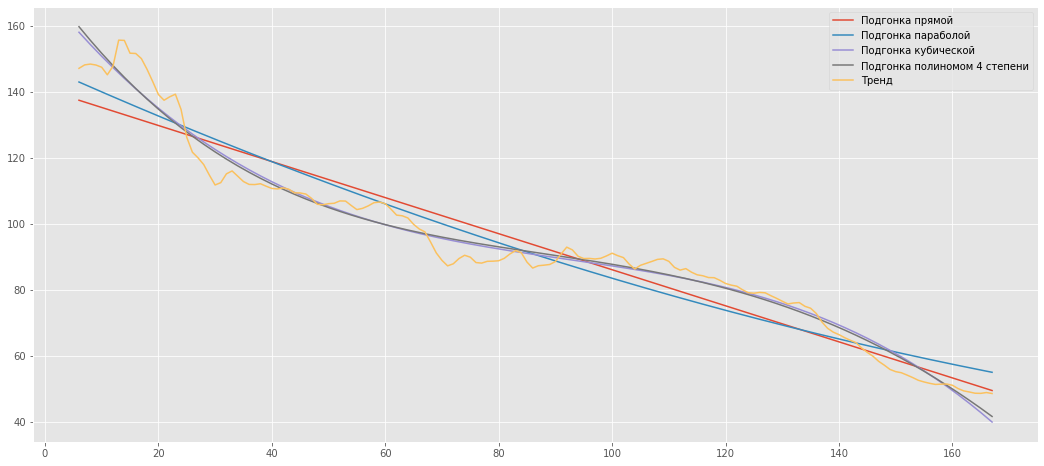

In [426]:
pred_trend = pd.DataFrame({
    'Подгонка прямой': y1,
    'Подгонка параболой': y2,
    'Подгонка кубической': y3,
    'Подгонка полиномом 4 степени': y4,
    'Тренд': y})
pred_trend.plot(figsize=(18,8))

Наиболее хорошим образом данный тренд описывается кубической моделью, так как принципиальной разницы нет, а она проще. Будем апроксимировать тренд кубической параболой (чтобы построить прогноз).

In [427]:
#  Готовим данные для вычисления прогнозов.
#  Модель уже отобрана и готова

X_forecast = pd.DataFrame({'month_num': range(175, 183)})

In [428]:
X_forecast['num^2'] = X_forecast['month_num']**2
X_forecast['num^3'] = X_forecast['month_num']**3

In [429]:
X_forecast

,month_num,num^2,num^3
0,175,30625,5359375
1,176,30976,5451776
2,177,31329,5545233
3,178,31684,5639752
4,179,32041,5735339
5,180,32400,5832000
6,181,32761,5929741
7,182,33124,6028568


In [430]:
X_forecast.shape[1]

3

In [431]:
# Прогноз для тренда

forecast_ = model3.predict(X_forecast)

forecast_

array([38.44419228, 36.91424196, 35.35043746, 33.75233721, 32.11949967,
       30.45148329, 28.74784653, 27.00814783])

In [432]:
#  Вспоминаем, как выглядят сезонные поправки

result.seasonal.head(24)

0     0.677131
1     0.811085
2     0.901424
3     0.840625
4     0.886292
5     0.923311
6     1.067005
7     1.042992
8     1.023362
9     1.021747
10    1.185282
11    1.619745
12    0.677131
13    0.811085
14    0.901424
15    0.840625
16    0.886292
17    0.923311
18    1.067005
19    1.042992
20    1.023362
21    1.021747
22    1.185282
23    1.619745
Name: seasonal, dtype: float64

In [433]:
#  Поскольку сезонные поправки мультипликативные, перемножаем.
#  Получаем прогноз на 8 наблюдений, то есть на 8 месяцев:

forecast_2 = forecast_ * result.seasonal.iloc[0:8]

In [434]:
horizon_ = 8

#   Номера месяцев, для которых делается прогноз:

valid = range(len(df_rose)+1, len(df_rose)+horizon_+1, 1)

In [435]:
list(valid)

[175, 176, 177, 178, 179, 180, 181, 182]

In [436]:
forecast_2.index = list(valid)

In [437]:
# Прогноз:

forecast_2

175    26.031752
176    29.940594
177    31.865737
178    28.373055
179    28.467249
180    28.116193
181    30.674090
182    28.169285
Name: seasonal, dtype: float64

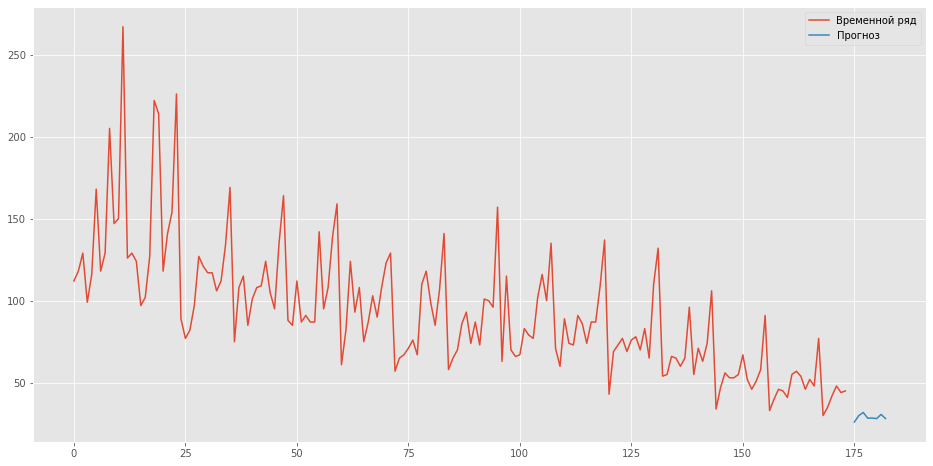

In [440]:
plt.figure(figsize=(16,8))
plt.plot(df_rose, label='Временной ряд')
plt.plot(forecast_2, label='Прогноз')
plt.legend(loc='best')


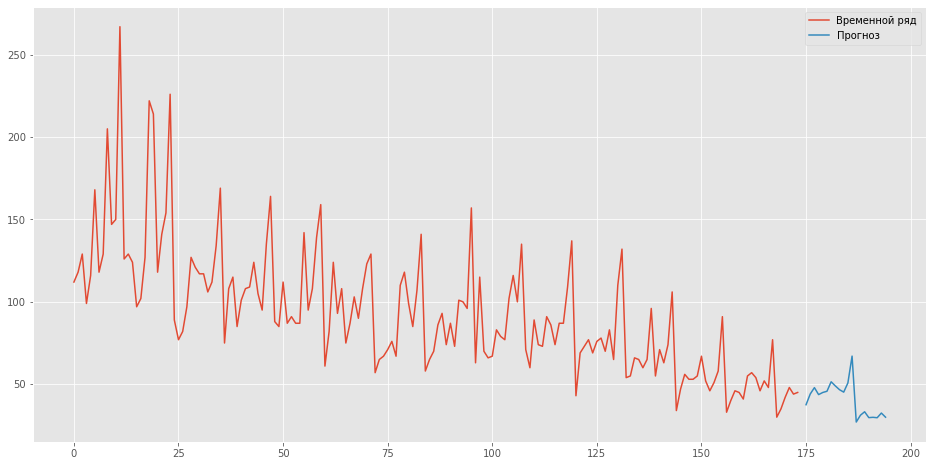

In [441]:
X_forecast_20 = pd.DataFrame({'month_num': range(162, 182)})
X_forecast_20['num^2'] = X_forecast_20['month_num']**2
X_forecast_20['num^3'] = X_forecast_20['month_num']**3

forecast_20 = model3.predict(X_forecast_20)

forecast_20_2 = forecast_20 * result.seasonal.iloc[0:20]

horizon_ = 20

#   Номера месяцев, для которых делается прогноз

#   valid = range(145, 157, 1) 

valid = range(len(df_rose)+1, len(df_rose)+horizon_+1, 1)

forecast_20_2.index = list(valid)


plt.figure(figsize=(16,8))
plt.plot(df_rose, label='Временной ряд')
plt.plot(forecast_20_2, label='Прогноз')
plt.legend(loc='best')
